In [ ]:
import sys
sys.path.append('/Users/chandrasekharmukherjee/Home/Centrality framework/Modules')
sys.path.append('/Users/chandrasekharmukherjee/Home/Centrality framework/Viz')
sys.path.append('/Users/chandrasekharmukherjee/Home/Centrality framework/MCPC_Clustering/Codes')

datapath='/Users/chandrasekharmukherjee/Home/Centrality framework/SCRNA_benchmark/'


In [ ]:
#Import packages
#imports
import time
import pandas as pd
from collections import Counter
import sknetwork


from sknetwork.ranking import PageRank
from sknetwork.ranking import Betweenness
from sknetwork.ranking import Closeness

import umap as umap

from numba.typed import List
import warnings
from numba import njit
import pynndescent
import numpy as np
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import operator
from sklearn.utils.extmath import randomized_svd
from random import randint
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
import scipy
from umap.umap_ import *
import math
from random import randint
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.datasets import cifar100
from keras.datasets import fashion_mnist
import scanpy
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score, roc_auc_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

import community as community_louvain
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score

from plots import *
import scipy

import igraph 
import networkx as nx


from sklearn.metrics.cluster import normalized_mutual_info_score as NMI


In [ ]:
%load_ext autoreload
%autoreload 2
import importlib

from plots import *


import benchmark as bmarks
import metric as met 
import FlowRank as algo
import datasets as dsets
import simulation as simm
import embedding as embed
import newflow as newalgo
import Relative_centrality_v2 as new_score
import Real_Custom_v2 as MCPC_cluster

met=importlib.reload(met)
newalgo=importlib.reload(newalgo)
algo = importlib.reload(algo)
dsets = importlib.reload(dsets)
simm = importlib.reload(simm)
embed=importlib.reload(embed)
bmarks=importlib.reload(bmarks)
new_score=importlib.reload(new_score)


MCPC_cluster=importlib.reload(MCPC_cluster)



In [ ]:
datanames = ['Baron_Human', 'Baron_Mouse', 'Muraro', 'Segerstolpe','Xin', 'Zhengmix8eq','Tcell-medicine','ALM', 'AMB', 'TM', 'VISP']


In [ ]:
name='Zhengmix8eq'
kchoice=20

X = scipy.sparse.load_npz(datapath+name + '/data.npz')
label = np.load(datapath+name+'/labels.npy')
print(name,len(label))

#Log transform+PCA
X.data = np.log1p(X.data)
print("Log transform done")
pca = TruncatedSVD(n_components=50)
PX = pca.fit_transform(X)
n=PX.shape[0]
walk_len_c1=int(np.log2(n))
print(PX.shape)


#Calculte inital KNN accuracy
met.KNN_graph_acc(PX,kchoice,0,label)

#Get the KNN edgelist
edge_list,vlist=embed.dir_KNN_graph(PX,kchoice,0)
print(len(edge_list))

In [ ]:
# This code is to test Louvain Method with custom Modularity Function
import numpy as np
import networkx as nx
import networkx.algorithms.community.quality as nx_quality
import networkx.algorithms.community as nx_comm
# from Custom_Func import directed_modularity, modularity, _one_level

import Custom_Func as Custom_Func

In [ ]:
from collections import defaultdict, deque

def get_labels(partition,n_s):
    final_partition_1 = deque(partition, maxlen=1).pop()
    #print(final_partition_1)


    label_1=np.zeros((n_s))
    c=0
    for sets in final_partition_1:
        for ell in sets:
            label_1[ell]=c
        
        c=c+1

    return label_1

In [ ]:
import tensorflow as tf
import random
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()

print(x_train.shape,y_train.shape)

X_F=x_train.reshape(x_train.shape[0], 784)
print(X_F.shape)
label_F=y_train

seq=[i for i in range(n)]
subset=random.sample(seq, n//5)

X=X_F[subset,:]
label=label_F[subset]

pca = TruncatedSVD(n_components=50)
PX = pca.fit_transform(X)
n=PX.shape[0]
walk_len_c1=int(np.log2(n))
print(PX.shape)


#Calculte inital KNN accuracy
met.KNN_graph_acc(PX,kchoice,0,label)

#Get the KNN edgelist
edge_list,vlist=embed.dir_KNN_graph(PX,kchoice,0)
print(len(edge_list))


In [ ]:
def plot_Loivain_NMI_purity(G,label,res_list):

    nmi=[]
    pr=[]
    for res in res_list:
        partition = nx_comm.louvain.louvain_partitions(G, seed=0,resolution=res)
        label_new=get_labels(partition,n)
        
        nmi_temp=NMI(label,label_new)
        pr_temp=met.purity_score(label,label_new)

        nmi.append(nmi_temp)
        pr.append(pr_temp)


    return nmi,pr


def plot_MCPC_NMI_purity(G,label,res_list):

    nmi=[]
    pr=[]

    for res in res_list:
        partition1=MCPC_cluster.louvain_partitions(G, seed=0,resolution=res)
        label_new1=get_labels(partition1,n)


        nmi_temp=NMI(label,label_new1)
        pr_temp=met.purity_score(label,label_new1)

        nmi.append(nmi_temp)
        pr.append(pr_temp)


In [80]:

node2FR = dict()



for i in algo.FLOW(edge_list,vlist,int(np.log2(n))):
    node_num = int(i[1])
    node2FR[node_num] = i[0]

G = nx.DiGraph()

G_wt=nx.DiGraph()

for (u,v) in edge_list:
    wt=(node2FR[u] * node2FR[v])**2
    G.add_edge(u,v,weight=1)
    G_wt.add_edge(u,v,weight=wt)

res_list=[i/100 for i in range(20,300,10)]
xv1,yv1=plot_Loivain_NMI_purity(G,label,res_list)
res_list=[i/100 for i in range(20,300,10)]
xv2,yv2=plot_Loivain_NMI_purity(G_wt,label,res_list)




3994


/Users/chandrasekharmukherjee/Home/Centrality framework/MCPC_Clustering/Codes/FlowRank.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  rank[v]=rank[v]+ 1/((max(v_cover[vset]))/(v_cover[v]))


In [82]:
res_list=[i/10 for i in range(5,30,2)]
xv1,yv1=plot_Loivain_NMI_purity(G,label,res_list)
xv2,yv2=plot_Loivain_NMI_purity(G_wt,label,res_list)

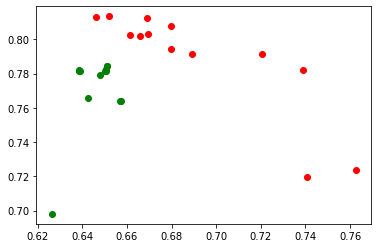

In [83]:
plt.Figure(figsize=(10,6))

plt.scatter(xv1,yv1,color='red')
plt.scatter(xv2,yv2,color='green')

In [ ]:
G = nx.DiGraph()
for (u,v) in edge_list:
    G.add_edge(u,v,weight=1)

#nx_comm.louvain._one_level=Custom_Func._one_level

res_list=[1,1.5,]

for res in res_list:
    partition = nx_comm.louvain.louvain_partitions(G, seed=0,resolution=res)
    label_new=get_labels(partition,n)
    print(round(NMI(label,label_new),2),round(met.purity_score(label,label_new),2),len(set(label_new)),res)

print("\n\n")

res_list=[1,2.5,5,17,34,51,68]


for res in res_list:
    partition1=MCPC_cluster.louvain_partitions(G, seed=0,resolution=res)
    label_new1=get_labels(partition1,n)
    print(round(NMI(label,label_new1),2),round(met.purity_score(label,label_new1),2),len(set(label_new1)),res)


In [ ]:
print(len(set(label_new1)))